In [1]:
import sacc
import numpy as np
import matplotlib.pyplot as plt
import h5py
import treecorr

In [2]:
# we are trying to reproduce the KiDS-1000 two-point real data vector 
# however, it has been unclear with whether or not the calibration that occurs in TXPipe is correct

In [3]:
# load the released data vector from Asgari et. al 2020 analysis downloaded from here:
# https://kids.strw.leidenuniv.nl/sciencedata.php

import astropy.io.fits as fits
path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/KiDS-1000_Datarelease/KiDS1000_cosmis_shear_data_release/data_fits/'
cat_version = 'V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid'
stats_name ='xipm'

filename = path+stats_name+'_KIDS1000_BlindC_with_m_bias_'+cat_version+'.fits'
F=fits.open(filename)

# Covariance matrix includes covariances for xip, xim and their cross covariance
extc=F["COVMAT"]
covariance= extc.data

# cosmic shear data vector: xi_plus
extx=F['xip']
xip=extx.data['VALUE']

# only taking the xip part of the cov
covxip = covariance[:135,:135]

In [4]:
# check two point for the 4,4 bin with data from SOM gold catalog downloaded here:
# https://kids.strw.leidenuniv.nl/DR4/KiDS-1000_shearcatalogue.php

with h5py.File("/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/shear_catalog_kids1000.h5","r") as f:
    with h5py.File("../../TXPipe/data/kids/outputs_m0c0/shear_tomography_catalog.hdf5") as g:
        source_bin = g["tomography/bin"][:]
        mask = source_bin ==4
        ra = f["shear/ra"][:][mask]
        dec = f["shear/dec"][:][mask]
        g1 = f["shear/g1"][:][mask]
        g2 = f["shear/g2"][:][mask]
        weight = f["shear/weight"][:][mask]
    g.close()
f.close()

cat = treecorr.Catalog(ra = ra,
                       dec = dec,
                       g1 = g1,
                       g2 =g2,
                       w = weight,
                       ra_units="degree",
                       dec_units="degree",
                       npatch = 40,
                       )

gg = treecorr.GGCorrelation(bin_slop =  0,
                            min_sep = 0.5,
                            max_sep= 300,
                            nbins= 9,
                            sep_units= "arcmin",
                            var_method= "jackknife",
                            metric= "Euclidean",
                            )
gg.process(cat)

In [5]:
# the additive biases c1, c2 are simply the weighted mean of the g1, g2 values per bin
# correcting is then g = g - c
# lets check this as well.

cat_ccorr = treecorr.Catalog(ra = ra,
                       dec = dec,
                       g1 = g1-np.mean(g1),
                       g2 =g2-np.mean(g2),
                       w = weight,
                       ra_units="degree",
                       dec_units="degree",
                       npatch = 40,
                       )

gg_ccorr = treecorr.GGCorrelation(bin_slop =  0,
                            min_sep = 0.5,
                            max_sep= 300,
                            nbins= 9,
                            sep_units= "arcmin",
                            var_method= "jackknife",
                            metric= "Euclidean",
                            )
gg_ccorr.process(cat_ccorr)

In [6]:
# In TXPipe, the additive correction is applied to g prior to running through two-point calcs
# Originally, I thought this was incorrect as Treecorr applies weighting in its calculation 
# Which would lead the C-correction to be weighted twice. Let's check this anyway.

c1 = np.average(g1, weights = weight)
c2 = np.average(g2, weights = weight)
g1TX = g1-c1
g2TX = g2-c2

cat_ccorrTX = treecorr.Catalog(ra = ra,
                       dec = dec,
                       g1 = g1TX,
                       g2 =g2TX,
                       w = weight,
                       ra_units="degree",
                       dec_units="degree",
                       npatch = 40,
                       )

gg_ccorrTX = treecorr.GGCorrelation(bin_slop =  0,
                            min_sep = 0.5,
                            max_sep= 300,
                            nbins= 9,
                            sep_units= "arcmin",
                            var_method= "jackknife",
                            metric= "Euclidean",
                            )
gg_ccorrTX.process(cat_ccorrTX)

Text(0.5, 0, '$\\theta$')

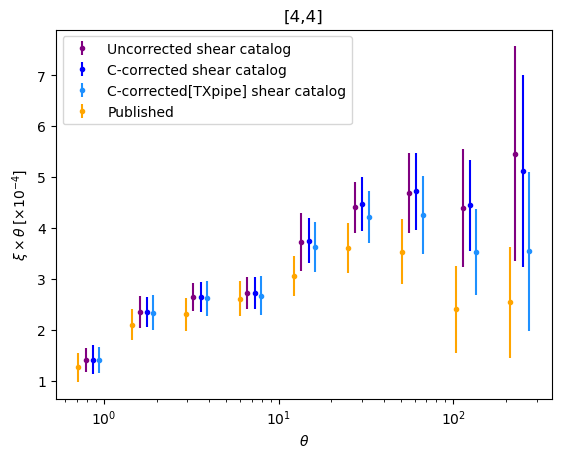

In [7]:
# checking results:
ij_msk = (extx.data['BIN2'] == 5) & (extx.data['BIN1'] == 5)

ptheta = extx.data['ANG'][ij_msk]
pxip = extx.data['VALUE'][ij_msk]
pcovxip = (np.diagonal(covxip))[ij_msk]

scale=1e-4
plt.errorbar(gg.meanr, gg.xip*gg.meanr / scale,
             np.sqrt(np.diagonal(gg.cov[:9]))*gg.meanr / scale,
             fmt='.',color='purple',label='Uncorrected shear catalog')

plt.errorbar(gg_ccorr.meanr+ 0.1*gg_ccorr.meanr, gg_ccorr.xip*gg_ccorr.meanr / scale, #add a shift
             np.sqrt(np.diagonal(gg_ccorr.cov[:9]))*gg_ccorr.meanr / scale,
             fmt='.',color='blue',label='C-corrected shear catalog')

plt.errorbar(gg_ccorrTX.meanr+ 0.2*gg_ccorrTX.meanr, gg_ccorrTX.xip*gg_ccorrTX.meanr / scale, #add a shift
             np.sqrt(np.diagonal(gg_ccorrTX.cov[:9]))*gg_ccorrTX.meanr / scale,
             fmt='.',color='dodgerblue',label='C-corrected[TXpipe] shear catalog')

plt.errorbar(ptheta, pxip*ptheta / scale,  np.sqrt(pcovxip)*ptheta / scale,
                               fmt='.',label='Published',color='orange')
plt.xscale('log')
plt.legend(loc='upper left')
plt.title('[4,4]')
plt.ylabel(r'$\xi \times \theta \:[\times 10^{-4}]$')
plt.xlabel(r'$\theta$')

In [ ]:
# we can check the ratio between these different results vs the published:
print(f"xip published/ xip calculated")
for i in range(len(pxip)-1):
    print(f"for element {i} : \n")
    print(f" UNCORRECTED: ", pxip[i+1]/gg.xip[i])
    print(f" C - CORRECTED:  : ", pxip[i+1]/gg_ccorr.xip[i])
    print(f" C - CORRECTED [TXPIPE]:  ", pxip[i+1]/gg_ccorrTX.xip[i])
    print("\n")

In [8]:
# at one point, TXPipe had a function to calibrate the g1 g2 by a multiplicative factor.
# this is the copied code from that

def apply_lensfit_calibration(g1, g2, weight, c1=0, c2=0, sigma_e=0, m=0):
    w_tot = np.sum(weight)
    m = np.sum(weight * m) / w_tot  # if m not provided, default is m=0, so one_plus_K=1
    one_plus_K = 1.0 + m
    R = 1.0 - np.sum(weight * sigma_e) / w_tot
    g1 = (1.0 / (one_plus_K)) * ((g1 / R) - c1)
    g2 = (1.0 / (one_plus_K)) * ((g2 / R) - c2)
    return g1, g2, weight, one_plus_K

In [9]:
# we will apply that calibration here 

with h5py.File("/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/shear_catalog_kids1000.h5","r") as f:
    with h5py.File("../../TXPipe/data/kids/outputs_m0c0/shear_tomography_catalog.hdf5") as g:
        source_bin = g["tomography/bin"][:]
        mask = source_bin ==4
        sigma_e = g["tomography/sigma_e"][-1]
        print(sigma_e)
        m       = f["shear/m"][:][mask]
        g1_cal, g2_cal, _ , _ = apply_lensfit_calibration(  g1      = g1,
                                                            g2      = g2,
                                                            weight  = weight,
                                                            sigma_e = sigma_e,
                                                            m       = m
                                                            )
    g.close()
f.close()

cat_cal = treecorr.Catalog(
            ra = ra,
            dec = dec,
            g1 = g1_cal,
            g2 = g2_cal,
            w = weight,
            ra_units="degree",
            dec_units="degree",
            npatch = 40,
        )
gg_cal = treecorr.GGCorrelation(bin_slop =  0,
                              min_sep = 0.5,
                              max_sep= 300,
                              nbins= 9,
                              sep_units= "arcmin",
                              var_method= "jackknife",
                              metric= "Euclidean",
                             )
gg_cal.process(cat_cal)

0.14000814


In [10]:
# there's lots of knobs in that correction function so let's check some different settings
# try m= 0

g1_calm0, g2_calm0, _ , _ = apply_lensfit_calibration(g1      = g1,
                                                      g2      = g2,
                                                      weight  = weight,
                                                      sigma_e = sigma_e,
                                                      )


cat_calm0 = treecorr.Catalog(
            ra = ra,
            dec = dec,
            g1 = g1_calm0,
            g2 = g2_calm0,
            w = weight,
            ra_units="degree",
            dec_units="degree",
            npatch = 40,
        )
gg_calm0 = treecorr.GGCorrelation(bin_slop =  0,
                              min_sep = 0.5,
                              max_sep= 300,
                              nbins= 9,
                              sep_units= "arcmin",
                              var_method= "jackknife",
                              metric= "Euclidean",
                             )
gg_calm0.process(cat_calm0)

In [11]:
# try R= 0

g1_calR0, g2_calR0, _ , _ = apply_lensfit_calibration(g1      = g1,
                                                      g2      = g2,
                                                      weight  = weight,
                                                      m       = m
                                                      )


cat_calR0 = treecorr.Catalog(
            ra = ra,
            dec = dec,
            g1 = g1_calR0,
            g2 = g2_calR0,
            w = weight,
            ra_units="degree",
            dec_units="degree",
            npatch = 40,
        )
gg_calR0 = treecorr.GGCorrelation(bin_slop =  0,
                              min_sep = 0.5,
                              max_sep= 300,
                              nbins= 9,
                              sep_units= "arcmin",
                              var_method= "jackknife",
                              metric= "Euclidean",
                             )
gg_calR0.process(cat_calR0)

In [12]:
# try m= 0, additive bias
# at this point, we're getting a bit complicated in our naming scheme. apologies 

g1_calm0_ccorr, g2_calm0_ccorr, _ , _ = apply_lensfit_calibration(g1      = g1,
                                                                  g2      = g2,
                                                                  weight  = weight,
                                                                  sigma_e = sigma_e,
                                                                  c1      = c1,
                                                                  c2      = c2
                                                                  )

cat_calm0_ccorr = treecorr.Catalog(
            ra = ra,
            dec = dec,
            g1 = g1_calm0_ccorr,
            g2 = g2_calm0_ccorr,
            w = weight,
            ra_units="degree",
            dec_units="degree",
            npatch = 40,
        )
gg_calm0_ccorr = treecorr.GGCorrelation(bin_slop =  0,
                              min_sep = 0.5,
                              max_sep= 300,
                              nbins= 9,
                              sep_units= "arcmin",
                              var_method= "jackknife",
                              metric= "Euclidean",
                             )
gg_calm0_ccorr.process(cat_calm0_ccorr)

In [14]:
# try 1+m, additive bias

g1_calR0_ccorr, g2_calR0_ccorr, _ , _ = apply_lensfit_calibration(g1      = g1,
                                                                  g2      = g2,
                                                                  weight  = weight,
                                                                  m       = m,
                                                                  c1      = c1,
                                                                  c2      = c2
                                                                  )

cat_calR0_ccorr = treecorr.Catalog(
            ra = ra,
            dec = dec,
            g1 = g1_calR0_ccorr,
            g2 = g2_calR0_ccorr,
            w = weight,
            ra_units="degree",
            dec_units="degree",
            npatch = 40,
        )
gg_calR0_ccorr = treecorr.GGCorrelation(bin_slop =  0,
                              min_sep = 0.5,
                              max_sep= 300,
                              nbins= 9,
                              sep_units= "arcmin",
                              var_method= "jackknife",
                              metric= "Euclidean",
                             )
gg_calR0_ccorr.process(cat_calR0_ccorr)

In [15]:
# try 1+m,R, additive bias 

g1_cal_ccorr, g2_cal_ccorr, _ , _ = apply_lensfit_calibration(g1      = g1,
                                                              g2      = g2,
                                                              weight  = weight,
                                                              sigma_e = sigma_e,
                                                              m       = m,              
                                                              c1      = c1,
                                                              c2      = c2
                                                              )

cat_cal_ccorr = treecorr.Catalog(
            ra = ra,
            dec = dec,
            g1 = g1_cal_ccorr,
            g2 = g2_cal_ccorr,
            w = weight,
            ra_units="degree",
            dec_units="degree",
            npatch = 40,
        )
gg_cal_ccorr = treecorr.GGCorrelation(bin_slop =  0,
                              min_sep = 0.5,
                              max_sep= 300,
                              nbins= 9,
                              sep_units= "arcmin",
                              var_method= "jackknife",
                              metric= "Euclidean",
                             )
gg_cal_ccorr.process(cat_cal_ccorr)

Text(0.5, 0, '$\\theta$')

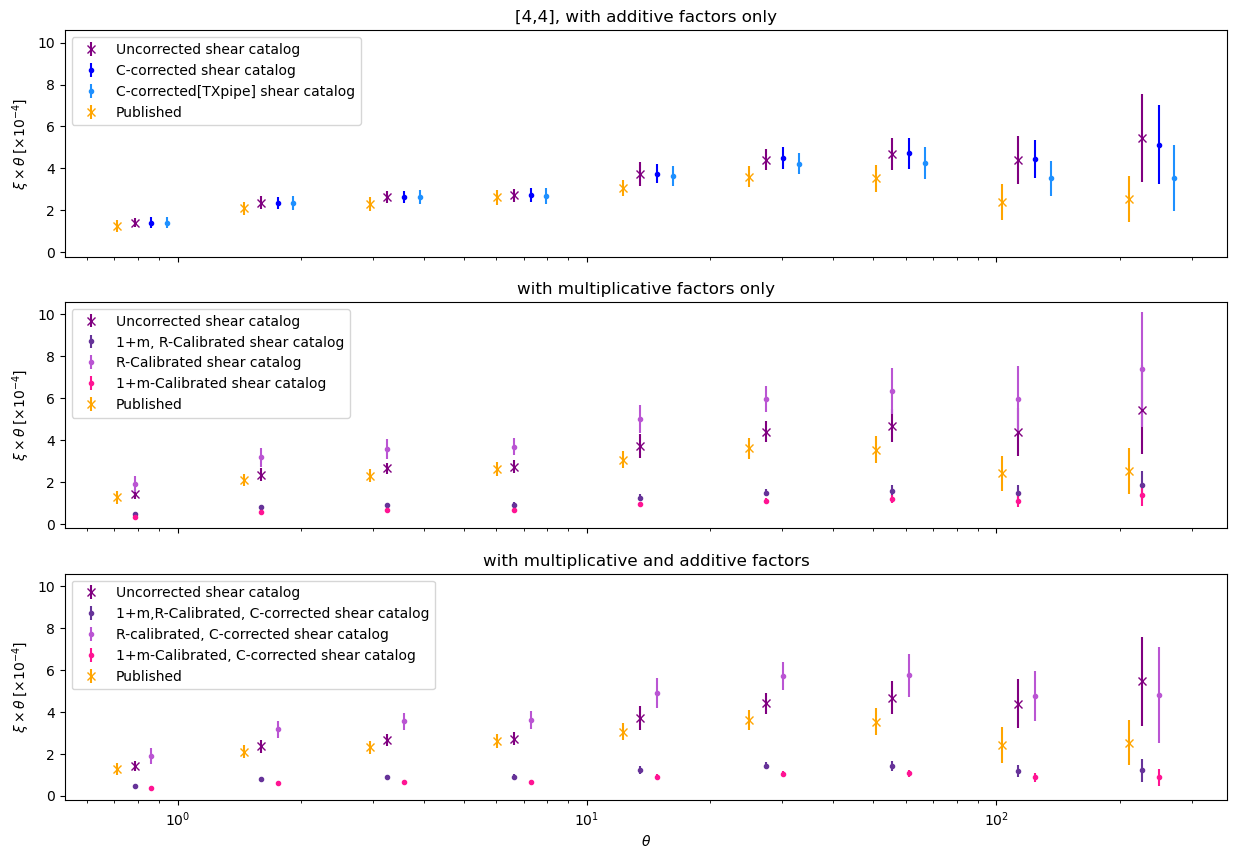

In [27]:
# checking results:
ij_msk = (extx.data['BIN2'] == 5) & (extx.data['BIN1'] == 5)

ptheta = extx.data['ANG'][ij_msk]
pxip = extx.data['VALUE'][ij_msk]
pcovxip = (np.diagonal(covxip))[ij_msk]

scale=1e-4
fig, axes = plt.subplots(3,1, sharex=True,sharey=True,figsize=(15,10))
ax0,ax1,ax2 = axes.flatten()

ax0.errorbar(gg.meanr, gg.xip*gg.meanr / scale,
             np.sqrt(np.diagonal(gg.cov[:9]))*gg.meanr / scale,
             fmt='x',color='purple',label='Uncorrected shear catalog')

ax0.errorbar(gg_ccorr.meanr+ 0.1*gg_ccorr.meanr, gg_ccorr.xip*gg_ccorr.meanr / scale, #add a shift
             np.sqrt(np.diagonal(gg_ccorr.cov[:9]))*gg_ccorr.meanr / scale,
             fmt='.',color='blue',label='C-corrected shear catalog')

ax0.errorbar(gg_ccorrTX.meanr+ 0.2*gg_ccorrTX.meanr, gg_ccorrTX.xip*gg_ccorrTX.meanr / scale, #add a shift
             np.sqrt(np.diagonal(gg_ccorrTX.cov[:9]))*gg_ccorrTX.meanr / scale,
             fmt='.',color='dodgerblue',label='C-corrected[TXpipe] shear catalog')

ax0.errorbar(ptheta, pxip*ptheta / scale,  np.sqrt(pcovxip)*ptheta / scale,
                               fmt='x',label='Published',color='orange')


#-----------------------------------------------------------------------------------
ax1.errorbar(gg.meanr, gg.xip*gg.meanr / scale,
             np.sqrt(np.diagonal(gg.cov[:9]))*gg.meanr / scale,
             fmt='x',color='purple',label='Uncorrected shear catalog')

ax1.errorbar(gg_cal.meanr, gg_cal.xip*gg_cal.meanr / scale,
             np.sqrt(np.diagonal(gg_cal.cov[:9]))*gg_cal.meanr / scale,
             fmt='.',color='rebeccapurple',label='1+m, R-Calibrated shear catalog')

ax1.errorbar(gg_calm0.meanr, gg_calm0.xip*gg_calm0.meanr / scale,
             np.sqrt(np.diagonal(gg_calm0.cov[:9]))*gg_calm0.meanr / scale,
             fmt='.',color='mediumorchid',label='R-Calibrated shear catalog')

ax1.errorbar(gg_calR0.meanr, gg_calR0.xip*gg_calR0.meanr / scale,
             np.sqrt(np.diagonal(gg_calR0.cov[:9]))*gg_calR0.meanr / scale,
             fmt='.',color='deeppink',label='1+m-Calibrated shear catalog')

ax1.errorbar(ptheta, pxip*ptheta / scale,  np.sqrt(pcovxip)*ptheta / scale,
                               fmt='x',label='Published',color='orange')

#-----------------------------------------------------------------------------------------------
ax2.errorbar(gg.meanr, gg.xip*gg.meanr / scale,
             np.sqrt(np.diagonal(gg.cov[:9]))*gg.meanr / scale,
             fmt='x',color='purple',label='Uncorrected shear catalog')

ax2.errorbar(gg_cal_ccorr.meanr , gg_cal_ccorr.xip*gg_cal_ccorr.meanr / scale,
             np.sqrt(np.diagonal(gg_cal_ccorr.cov[:9]))*gg_cal_ccorr.meanr / scale,
             fmt='.',color='rebeccapurple',label='1+m,R-Calibrated, C-corrected shear catalog')

ax2.errorbar(gg_calm0_ccorr.meanr +0.1*gg_calm0_ccorr.meanr, gg_calm0_ccorr.xip*gg_calm0_ccorr.meanr / scale,
             np.sqrt(np.diagonal(gg_calm0_ccorr.cov[:9]))*gg_calm0_ccorr.meanr / scale,
             fmt='.',color='mediumorchid',label='R-calibrated, C-corrected shear catalog')

ax2.errorbar(gg_calR0_ccorr.meanr +0.1*gg_calR0_ccorr.meanr, gg_calR0_ccorr.xip*gg_calR0_ccorr.meanr / scale,
             np.sqrt(np.diagonal(gg_calR0_ccorr.cov[:9]))*gg_calR0_ccorr.meanr / scale,
             fmt='.',color='deeppink',label='1+m-Calibrated, C-corrected shear catalog')

ax2.errorbar(ptheta, pxip*ptheta / scale,  np.sqrt(pcovxip)*ptheta / scale,
                               fmt='x',label='Published',color='orange')
ax2.set_xscale('log')

ax0.legend(loc='upper left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax0.set_ylabel(r'$\xi \times \theta \:[\times 10^{-4}]$')
ax1.set_ylabel(r'$\xi \times \theta \:[\times 10^{-4}]$')
ax2.set_ylabel(r'$\xi \times \theta \:[\times 10^{-4}]$')

ax0.set_title('[4,4], with additive factors only')
ax1.set_title('with multiplicative factors only')
ax2.set_title(r'with multiplicative and additive factors')
ax2.set_xlabel(r'$\theta$')